In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy reconstruction (MODEL)

This notebook contains the same code as in `protopipe.scripts.model_diagnostic`.
It should be used to test the performance of the trained model **before** use it to estimate the energy of DL2 events.

In fact, what happens in a *protopipe* analysis is that part of the TRAINING sample is used for *testing* the models to get some preliminary diagnostics.
This notebook shows this camera-wise preliminary diagnostics.

Settings and setup of the plots are done using the same configuration file used for training the model.

**Developers**  
Please, if you have any contribution regarding this part, do it here and not in the relevant sections of the main code, which are now discontinued.

## Table of contents

* [Feature importance](#Feature-importance)
* [Feature distributions](#Feature-distributions)
* [Migration distribution](#Migration-distribution)
* [Energy resolution and bias](#Energy-resolution-and-bias)

## Imports
[back to top](#Table-of-contents)

In [2]:
import gzip
import glob
from os import path

import pickle
import joblib
import yaml
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'figure.max_open_warning': 0})

## Functions and classes
[back to top](#Table-of-contents)

In [3]:
def load_config(name):
    """Load YAML configuration file."""
    try:
        with open(name, "r") as stream:
            cfg = yaml.load(stream, Loader=yaml.FullLoader)
    except FileNotFoundError as e:
        print(e)
        raise
    return cfg

In [4]:
def load_obj(name ):
    """Load object in binary"""
    with gzip.open(name, 'rb') as f:
        return pickle.load(f)

In [5]:
def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

In [6]:
def plot_distributions(feature_list,
                       data_list,
                       nbin=30,
                       hist_kwargs_list={},
                       error_kw_list={},
                       ncols=2):
    """Plot feature distributions for several data set. Returns list of axes."""
    n_feature = len(feature_list)
    nrows = int(n_feature / ncols) if n_feature % ncols == 0 else int((n_feature + 1) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    if nrows == 1 and ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, colname in enumerate(feature_list):
        ax = axes[i]

        # Range for binning
        range_min = min([data[colname].min() for data in data_list])
        range_max = max([data[colname].max() for data in data_list])
        myrange = [range_min, range_max]

        for j, data in enumerate(data_list):
            ax = plot_hist(
                ax=ax, data=data[colname], nbin=nbin, limit=myrange,
                norm=True, yerr=True,
                hist_kwargs=hist_kwargs_list[j],
                error_kw=error_kw_list[j]
            )

        ax.set_xlabel(colname)
        ax.set_ylabel('Arbitrary units')
        ax.legend(loc='upper left')
        ax.grid()
    plt.tight_layout()

    return fig, axes

In [7]:
def get_evt_subarray_model_output(data,
                                  weight_name=None,
                                  keep_cols=['reco_energy'],
                                  model_output_name='score_img',
                                  model_output_name_evt='score'):
    """
    Returns DataStore with keepcols + score/target columns of model at the
    level-subarray-event.
    
    Parameters
    ----------
    data: `~pandas.DataFrame`
        Data frame
    weight_name: `str`
        Variable name in data frame to weight events with
    keep_cols: `list`, optional
        List of variables to keep in resulting data frame
    model_output_name: `str`, optional
        Name of model output (image level)
    model_output_name: `str`, optional
        Name of averaged model output (event level)
    
    Returns
    --------
    data: `~pandas.DataFrame`
        Data frame
    """

    keep_cols += [model_output_name]
    keep_cols += [weight_name]
    new_data = data[keep_cols].copy(deep=True)

    new_data[model_output_name_evt] = np.zeros(len(new_data))
    new_data.set_index(["tel_id"], append=True, inplace=True)

    new_data[model_output_name_evt] = new_data.groupby(["obs_id", "event_id"]).apply(
        lambda g: np.average(g[model_output_name], weights=g[weight_name])
    )

    # Remove columns
    new_data = new_data.drop(columns=[model_output_name])

    # Remove duplicates
    new_data = new_data[~new_data.index.duplicated(keep="first")]

    return new_data

In [8]:
class ModelDiagnostic(object):
    """
    Base class for model diagnostics.
    
    Parameters
    ----------
    model: `~sklearn.base.BaseEstimator`
        Best model
    feature_name_list: list
        List of the features used to buil the model
    target_name: str
        Name of the target (e.g. score, gamaness, energy, etc.)
    """
    def __init__(self, model, feature_name_list, target_name):
        self.model = model
        self.feature_name_list = feature_name_list
        self.target_name = target_name

    def plot_feature_importance(self, ax, **kwargs):
        """
        Plot importance of features
        Parameters
        ----------
        ax: `~matplotlib.axes.Axes`
            Axis
        """
        if ax is None:
            import matplotlib.pyplot as plt
            ax = plt.gca()

        importance = self.model.feature_importances_
        importance, feature_labels = \
            zip(*sorted(zip(importance, self.feature_name_list), reverse=True))

        bin_edges = np.arange(0, len(importance)+1)
        bin_width = bin_edges[1:] - bin_edges[:-1] - 0.1

        ax.bar(bin_edges[:-1], importance, width=bin_width, **kwargs)
        ax.set_xticks(np.arange(0, len(importance)))
        ax.set_xticklabels(feature_labels, rotation=75)

        return ax

    def plot_features(self, data_list,
                      nbin=30,
                      hist_kwargs_list={},
                      error_kw_list={},
                      ncols=2):
        """
        Plot model features for different data set (e.g. training and test samples).
        Parameters
        ----------
        data_list: list
            List of data
        nbin: int
            Number of bin
        hist_kwargs_list: dict
            Dictionary with histogram options
        error_kw_list: dict
            Dictionary with error bar options
        ncols: int
            Number of columns
        """
        return plot_distributions(
            self.feature_name_list,
            data_list,
            nbin,
            hist_kwargs_list,
            error_kw_list, ncols
        )

    def add_image_model_output(self):
        raise NotImplementedError("Please Implement this method")

In [9]:
class RegressorDiagnostic(ModelDiagnostic):
    """
    Class to plot several diagnostic plots for regression.
    
    Parameters
    ----------
    model: sklearn.base.BaseEstimator
        Scikit model
    feature_name_list: str
        List of features
    target_name: str
        Name of target (e.g. `mc_energy`)
    data_train: `~pandas.DataFrame`
        Data frame
    data_test: `~pandas.DataFrame`
        Data frame
    """
    def __init__(self, model, feature_name_list, target_name, data_train, data_test, output_name):
        super().__init__(model, feature_name_list, target_name)

        self.data_train = data_train
        self.data_test = data_test

        self.target_estimation_name = self.target_name

        self.output_name = output_name
        self.output_name_img = output_name + '_img'

        # Compute and add target estimation
        self.data_train = self.add_image_model_output(
            self.data_train,
            col_name=self.output_name_img
        )
        self.data_test = self.add_image_model_output(
            self.data_test,
            col_name=self.output_name_img
        )

    @staticmethod
    def plot_resolution_distribution(ax, y_true, y_reco, nbin=100, fit_range=[-3,3],
                                     fit_kwargs={}, hist_kwargs={}):
        """
        Compute bias and resolution with a gaussian fit
        and return a plot with the fit results and the migration distribution.
        """

        def gauss(x, ampl, mean, std):
            return ampl * np.exp(-0.5 * ((x - mean) / std) ** 2)

        if ax is None:
            ax = plt.gca()

        migration = (y_reco - y_true) / y_true
        bin_edges = np.linspace(fit_range[0], fit_range[-1], nbin + 1, True)
        y, tmp = np.histogram(migration, bins=bin_edges)
        x = (bin_edges[:-1] + bin_edges[1:]) / 2

        try:
            param, cov = curve_fit(gauss, x, y)
        except:
            param = [-1, -1, -1]
            cov = [[]]
            #print('Not enough stat ? (#evts={})'.format(len(y_true)))

        plot_hist(
            ax=ax, data=migration, nbin=nbin,
            yerr=False,
            norm=False,
            limit=fit_range,
            hist_kwargs=hist_kwargs
        )

        ax.plot(x, gauss(x, param[0], param[1], param[2]), **fit_kwargs)

        return ax, param, cov

    def add_image_model_output(self, data, col_name):
        data[col_name] = self.model.predict(data[self.feature_name_list])
        return data

## Load models
[back to top](#Table-of-contents)

In [10]:
# Please, if you modify this notebook through a pull request empty these variables before pushing
analysesDir = "" # Where all your analyses are stored
analysisName = "" # The name of this analysis

In [11]:
configuration = f"{analysesDir}/{analysisName}/configs/regressor.yaml"

cfg = load_config(configuration)
model_type = cfg["General"]["model_type"]
method_name = cfg["Method"]["name"]

inDir = f"{analysesDir}/{analysisName}/estimators/energy_regressor"
cameras = [model.split('/')[-1].split('_')[2] for model in glob.glob(f"{inDir}/regressor*.pkl.gz")]

In [12]:
data = {camera : dict.fromkeys(["model", "data_scikit", "data_train", "data_test"]) for camera in cameras} 

for camera in cameras:

    data[camera]["data_scikit"] = load_obj(
                glob.glob(f"{inDir}/data_scikit_{model_type}_{method_name}_*_{camera}.pkl.gz")[0]
                )
    data[camera]["data_train"] = pd.read_pickle(
        glob.glob(f"{inDir}/data_train_{model_type}_{method_name}_*_{camera}.pkl.gz")[0]
                )
    data[camera]["data_test"] = pd.read_pickle(
        glob.glob(f"{inDir}/data_test_{model_type}_{method_name}_*_{camera}.pkl.gz")[0]
    )
    
    modelName = f"{model_type}_*_{camera}_{method_name}.pkl.gz"
    data[camera]["model"] = joblib.load(glob.glob(f"{inDir}/{modelName}")[0])

## Settings and setup
[back to top](#Table-of-contents)

In [13]:
# Energy (both true and reconstructed)
nbins = cfg["Diagnostic"]["energy"]["nbins"]

energy_edges = np.logspace(
        np.log10(cfg["Diagnostic"]["energy"]["min"]),
        np.log10(cfg["Diagnostic"]["energy"]["max"]),
        nbins + 1,
        True,
    )

In [14]:
diagnostic = dict.fromkeys(cameras)
for camera in cameras:
    diagnostic[camera] = RegressorDiagnostic(
                    model=data[camera]["model"],
                    feature_name_list=cfg["FeatureList"],
                    target_name="true_energy",
                    data_train=data[camera]["data_train"],
                    data_test=data[camera]["data_test"],
                    output_name="reco_energy",
                )

## Benchmarks
[back to top](#Table-of-contents)

### Feature importance
[back to top](#Table-of-contents)

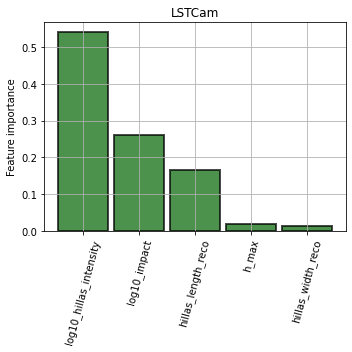

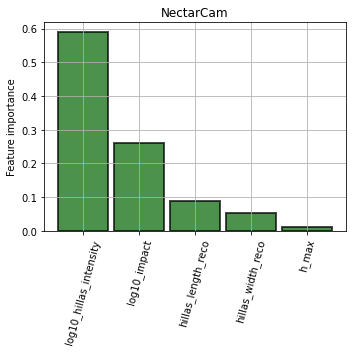

In [15]:
for camera in cameras:
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax = diagnostic[camera].plot_feature_importance(
        ax,
        **{"alpha": 0.7, "edgecolor": "black", "linewidth": 2, "color": "darkgreen"}
    )
    ax.set_ylabel("Feature importance")
    ax.grid()
    plt.title(camera)
    plt.tight_layout()

### Feature distributions
[back to top](#Table-of-contents)

                                                  LSTCam                                           
                                                  NectarCam                                           


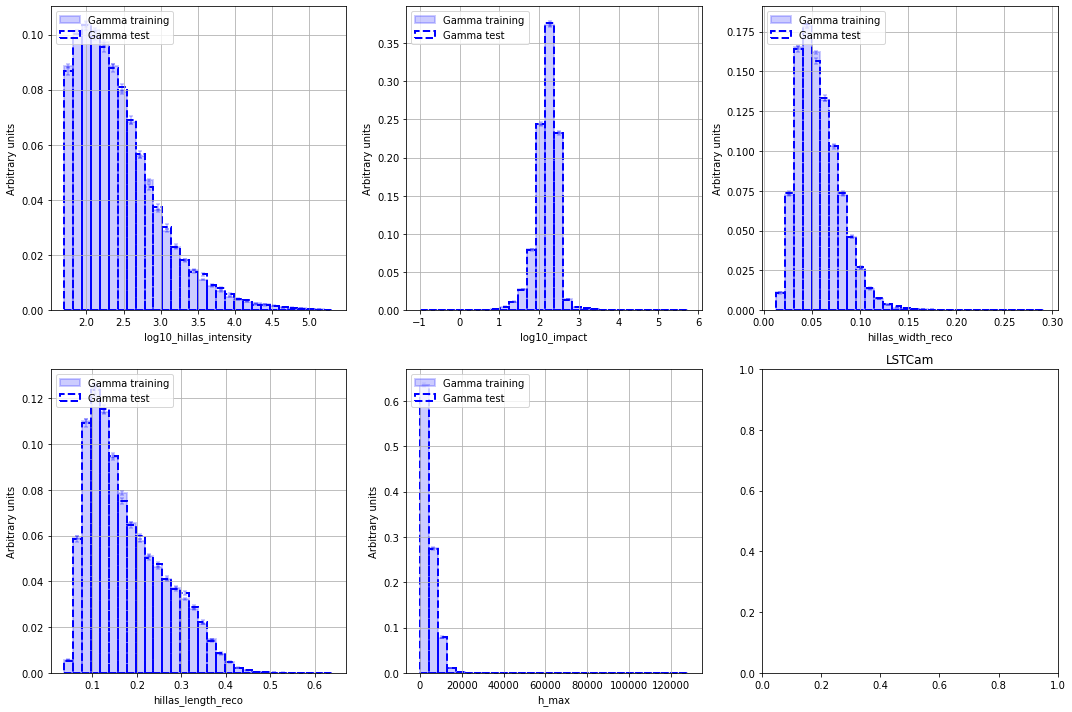

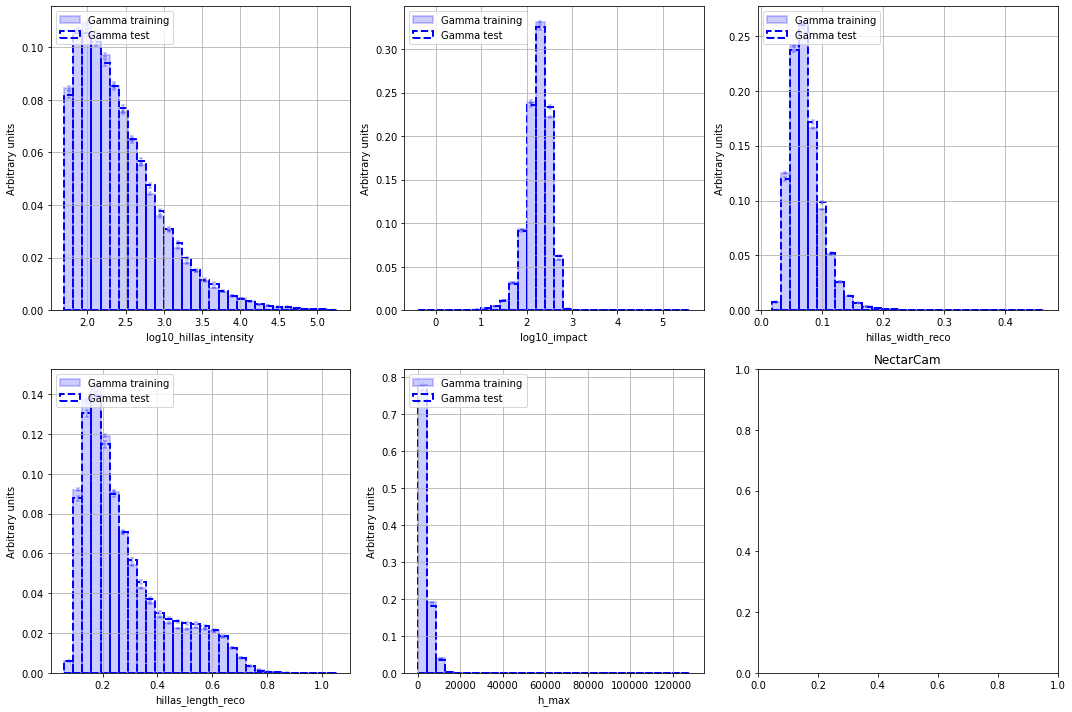

In [16]:
for camera in cameras:
    
    print("              ====================================================================================")
    print(f"                                                  {camera}                                           ")
    print("              ====================================================================================")
    
    fig, axes = diagnostic[camera].plot_features(
        data_list=[data[camera]["data_train"], data[camera]["data_test"]],
        nbin=30,
        hist_kwargs_list=[
            {
                "edgecolor": "blue",
                "color": "blue",
                "label": "Gamma training",
                "alpha": 0.2,
                "fill": True,
                "ls": "-",
                "lw": 2,
            },
            {
                "edgecolor": "blue",
                "color": "blue",
                "label": "Gamma test",
                "alpha": 1,
                "fill": False,
                "ls": "--",
                "lw": 2,
            },
        ],
        error_kw_list=[
            dict(ecolor="blue", lw=2, capsize=2, capthick=2, alpha=0.2),
            dict(ecolor="blue", lw=2, capsize=2, capthick=2, alpha=0.2),
        ],
        ncols=3,
    )
    plt.title(camera)
    fig.tight_layout()

### Migration distribution
[back to top](#Table-of-contents)

                                                  LSTCam                                           


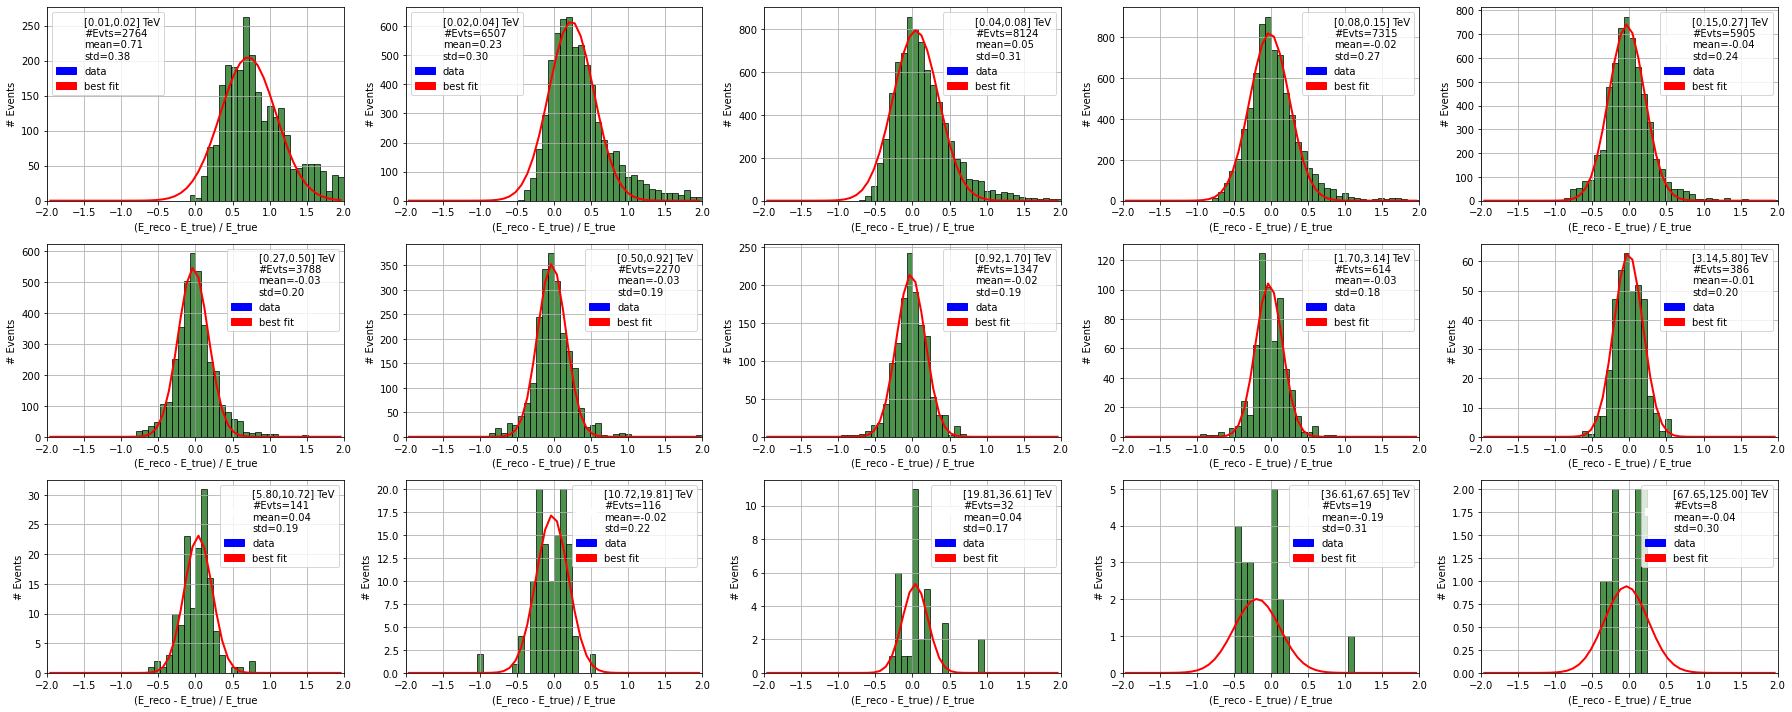

                                                  NectarCam                                           


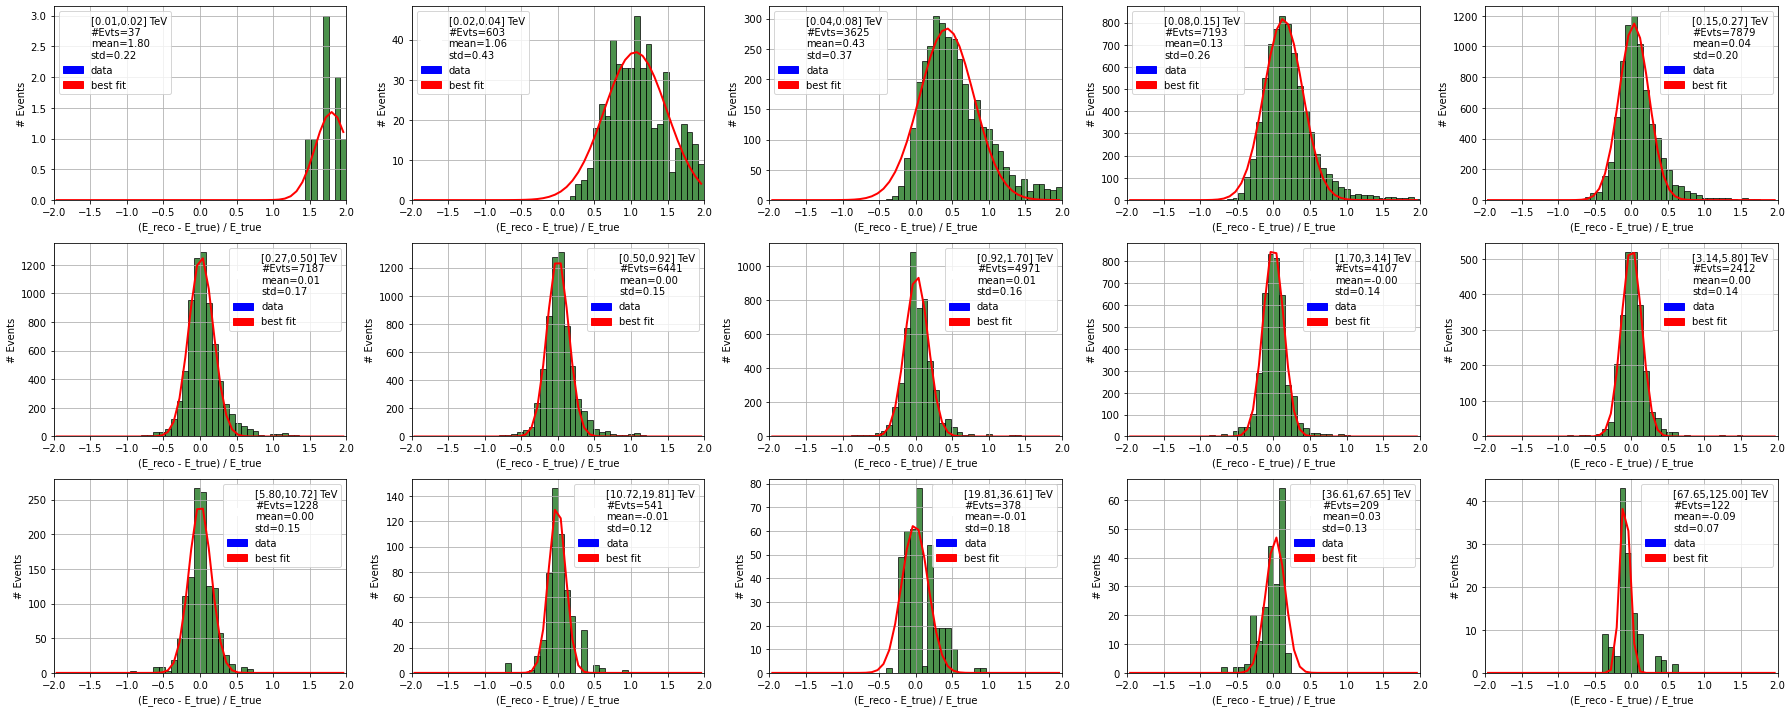

In [17]:
for camera in cameras:
    # Compute averaged energy
    # print("Process test sample...")
    
    print("              ====================================================================================")
    print(f"                                                  {camera}                                           ")
    print("              ====================================================================================")
    
    data_test_evt = get_evt_subarray_model_output(
        data[camera]["data_test"],
        weight_name="hillas_intensity_reco",
        keep_cols=["tel_id", "true_energy"],
        model_output_name="reco_energy_img",
        model_output_name_evt="reco_energy",
    )

    ncols = 5
    nrows = (
        int(nbins / ncols) if nbins % ncols == 0 else int((nbins + 1) / ncols)
    )
    if nrows == 0:
        nrows = 1
        ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * 5, 10))
    try:
        axes = axes.flatten()
    except:
        axes = [axes]

    bias = []
    resolution = []
    energy_centres = []

    for ibin in range(len(energy_edges) - 1):
        ax = axes[ibin]

        test_data = data_test_evt.query(
            "true_energy >= {} and true_energy < {}".format(
                energy_edges[ibin], energy_edges[ibin + 1]
            )
        )
        # print("Estimate energy for {} evts".format(len(test_data)))

        er = test_data["reco_energy"]
        emc = test_data["true_energy"]

        opt_hist = {
            "edgecolor": "black",
            "color": "darkgreen",
            "label": "data",
            "alpha": 0.7,
            "fill": True,
        }
        opt_fit = {"c": "red", "lw": 2, "label": "Best fit"}
        ax, fit_param, cov = diagnostic[camera].plot_resolution_distribution(
            ax=ax,
            y_true=emc,
            y_reco=er,
            nbin=50,
            fit_range=[-2, 2],
            hist_kwargs=opt_hist,
            fit_kwargs=opt_fit,
        )
        if fit_param[2] < 0:  # negative value are allowed for the fit
            fit_param[2] *= -1

        label = "[{:.2f},{:.2f}] TeV\n#Evts={}\nmean={:.2f}\nstd={:.2f}".format(
            energy_edges[ibin],
            energy_edges[ibin + 1],
            len(er),
            fit_param[1],
            fit_param[2],
        )

        ax.set_ylabel("# Events")
        ax.set_xlabel("(E_reco - E_true) / E_true")
        ax.set_xlim([-2, 2])
        ax.grid()

        evt_patch = mpatches.Patch(color="white", label=label)
        data_patch = mpatches.Patch(color="blue", label="data")
        fit_patch = mpatches.Patch(color="red", label="best fit")
        ax.legend(loc="best", handles=[evt_patch, data_patch, fit_patch])
        plt.tight_layout()

        #print(
        #    " Fit results: ({:.3f},{:.3f} TeV)".format(
        #        energy_edges[ibin], energy_edges[ibin + 1]
        #    )
        #)

        #try:
        #    print(" - A    : {:.3f} +/- {:.3f}".format(fit_param[0], cov[0][0]))
        #    print(" - mean : {:.3f} +/- {:.3f}".format(fit_param[1], cov[1][1]))
        #    print(" - std  : {:.3f} +/- {:.3f}".format(fit_param[2], cov[2][2]))
        #except:
        #    print(" ==> Problem with fit, no covariance...".format())
        #    continue

        bias.append(fit_param[1])
        resolution.append(fit_param[2])
        energy_centres.append(
            (energy_edges[ibin] + energy_edges[ibin + 1]) / 2.0
        )
    plt.show()

### Energy resolution and bias
[back to top](#Table-of-contents)

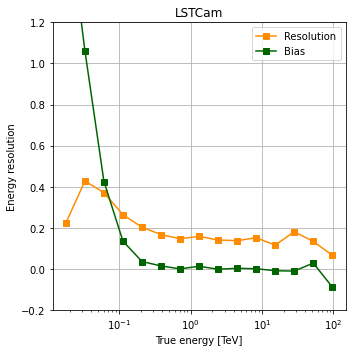

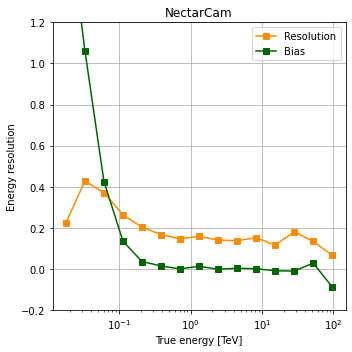

In [18]:
for camera in cameras:
    
    plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.plot(
        energy_centres,
        resolution,
        marker="s",
        color="darkorange",
        label="Resolution",
    )
    ax.plot(energy_centres, bias, marker="s", color="darkgreen", label="Bias")
    ax.set_xlabel("True energy [TeV]")
    ax.set_ylabel("Energy resolution")
    ax.set_xscale("log")
    ax.grid()
    ax.legend()
    ax.set_ylim([-0.2, 1.2])
    plt.title(camera)
    plt.tight_layout()